In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, minimize
from scipy.stats import skew, kurtosis, jarque_bera, chi2, t
import scipy.linalg

from numdifftools import Hessian
import numdifftools as nd

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import chi2

from tqdm import tqdm
import os
from PIL import Image

In [4]:
# btc = pd.read_csv('bitcoin.csv', index_col=0, parse_dates=True)[['prices']]
# btc = pd.read_csv('btc-usd-max.csv', index_col=0, parse_dates=True)[['price']]

btc = pd.DataFrame(pd.read_csv('btc.csv', index_col=0, parse_dates=True).iloc[:, 0])
btc = btc[btc.iloc[:, 0] != 0]

btc.columns = ['BTC']
btc.index.name = 'Date'

btc['Log BTC'] = np.log(btc['BTC'])

btc['Returns'] = np.log(btc['BTC'] / btc['BTC'].shift(1))
btc = btc.iloc[1:]

display(btc.round(4).head())

,BTC,Log BTC,Returns
Date,,,
2010-08-18,0.0740,-2.6037,-0.0384
2010-08-19,0.0688,-2.6766,-0.0729
2010-08-20,0.0667,-2.7076,-0.0310
2010-08-21,0.0669,-2.7046,0.0030
2010-08-22,0.0664,-2.7121,-0.0075


## EDA

In [5]:
EDA_table = pd.DataFrame({
    'Mean': [btc['Returns'].mean()],
    'Median': [btc['Returns'].median()],
    'Std': [btc['Returns'].std()],
    'Skew': [skew(btc['Returns'].values)],
    'Kurtosis': [kurtosis(btc['Returns'].values, fisher=False)],
    'JB Stat': [jarque_bera(btc['Returns'].values)[0]],
    'JB P': [jarque_bera(btc['Returns'].values)[1]]
})

print(EDA_table.round(4))

     Mean  Median     Std    Skew  Kurtosis       JB Stat  JB P
0  0.0026  0.0006  0.0519  0.8656   78.3372  1.258303e+06   0.0


EDA (period from the paper - Jan 2013 to Nov 2013)

In [12]:
btc_paper = btc.loc['2013-01-01':'2013-11-01']

EDA_table_paper = pd.DataFrame({
    'Mean': [btc_paper['Returns'].mean()],
    'Median': [btc_paper['Returns'].median()],
    'Std': [btc_paper['Returns'].std()],
    'Skew': [skew(btc_paper['Returns'].values)],
    'Kurtosis': [kurtosis(btc_paper['Returns'].values, fisher=False)],
    'JB Stat': [jarque_bera(btc_paper['Returns'].values)[0]],
    'JB P': [jarque_bera(btc_paper['Returns'].values)[1]]
})

print(EDA_table_paper.round(4))

     Mean  Median     Std    Skew  Kurtosis    JB Stat  JB P
0  0.0089   0.007  0.0703 -1.4249   19.6495  3626.0283   0.0


## Price, Returns Time-series Plot

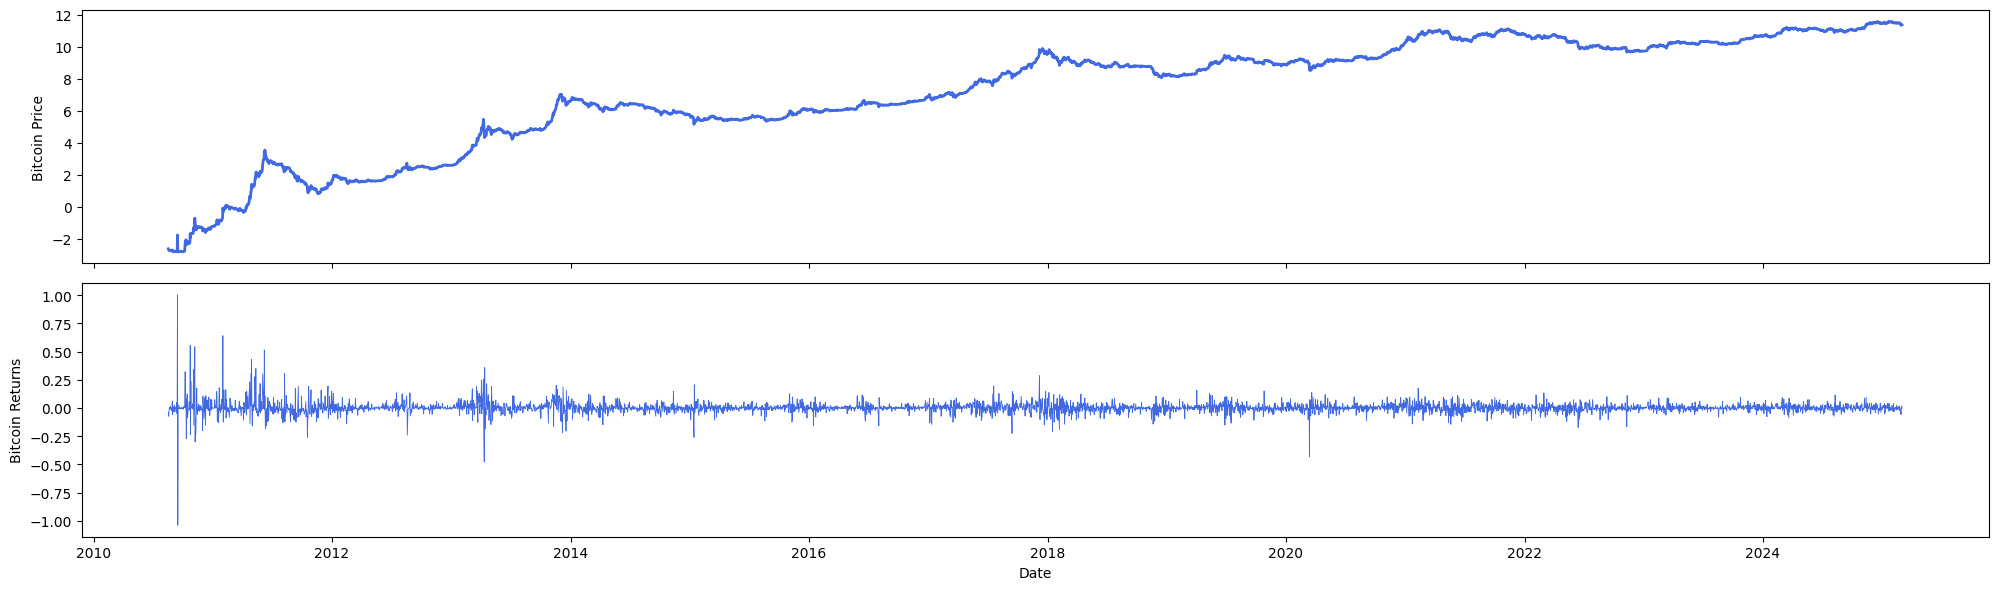

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

ax[0].plot(btc.index, btc['Log BTC'], linewidth=2, c='royalblue')
ax[0].set_ylabel("Bitcoin Price")

ax[1].plot(btc.index, btc['Returns'], linewidth=0.6, c='royalblue')
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Bitcoin Returns")

plt.tight_layout()
plt.show()

## Table 2: Parameter estimates of the stochastic bubble model.

In [48]:
def hazard(t, alpha, beta):
    return (beta * t**(beta-1)) / (alpha**beta + t**beta)

def H_integral(t, alpha, beta):
    return np.log1p((t / alpha)**beta) # np.log1p(x) = np.log(1+x), more stable

def PF(t, log_p0, mu_tilde):
    return log_p0 + mu_tilde * t

def PB(t, log_p0, mu_tilde, v, alpha, beta):
    Ht = H_integral(t, alpha, beta)
    return log_p0 + mu_tilde * t + (v - v**2 / 2) * Ht

def objective(params, times, log_prices, log_p0, mu_tilde):
    v, alpha, beta = params
    pred_log_prices = PB(times, log_p0, mu_tilde, v, alpha, beta)
    log_error = log_prices - pred_log_prices
    # print(np.sum(log_error**2))
    return np.sum(log_error**2)

def objective(params, times, log_prices, log_p0):
    v, mu_tilde, alpha, beta = params
    pred_log_prices = PB(times, log_p0, mu_tilde, v, alpha, beta)
    log_error = log_prices - pred_log_prices
    if not np.isfinite(np.sum(log_error**2)):
        return 1e20
    # print(np.sum(log_error**2))
    return np.sum(log_error**2)

In [88]:
start_date = '2013-01-01'
end_date   = '2013-11-30'

rolling = btc.loc[start_date:end_date].copy()
rolling['t'] = (rolling.index - rolling.index[0]).days.astype(float)

times = rolling['t'].values
prices = rolling['Log BTC'].values
p0 = prices[0]

mu_hat = rolling['Returns'].mean()
var_hat = rolling['Returns'].var()
mu_tilde_0 = mu_hat + 0.5 * var_hat

initial_guess = [0, mu_tilde_0, 1, 1]   # v, mu, alpha, beta
bounds = [(0, None), (None, None), (1e-5, 10000), (1e-5, 10000)]

# result = minimize(objective, initial_guess, args=(times, prices, p0, mu_tilde), bounds=bounds, method='Powell', options={'maxiter': 10000, 'xtol': 1e-20, 'ftol': 1e-20})
# result = minimize(objective, initial_guess, args=(times, prices, p0, mu_tilde), bounds=bounds, method='Powell')
result = minimize(objective, initial_guess, args=(times, prices, p0), bounds=bounds)
v_hat, mu_tilde_hat, alpha_hat, beta_hat = result.x

In [89]:
print('p0        =', p0.round(4))
print('mu_hat    =', mu_hat.round(4))
print('var_hat   =', var_hat.round(4))
print('mu_tilde  =', mu_tilde_hat.round(4))
print()
print('v_hat     =', v_hat.round(4))
print('alpha_hat =', alpha_hat.round(4))
print('beta_hat  =', beta_hat.round(4))

p0        = 2.6072
mu_hat    = 0.0132
var_hat   = 0.0051
mu_tilde  = 0.0012

v_hat     = 0.0704
alpha_hat = 15.5863
beta_hat  = 11.8766


In [90]:
hessian_func = nd.Hessian(lambda params: objective(params, times, prices, p0))
H = hessian_func(result.x)

n = len(times)
p = 4  # df: mu_tilde, v, alpha, beta

sse = objective(result.x, times, prices, p0)
sigma2 = sse / (n - p)

cov_matrix = 2 * sigma2 * np.linalg.pinv(H)

eigvals, eigvecs = np.linalg.eigh(cov_matrix)
eigvals_clipped = np.clip(eigvals, 1e-10, None)
cov_pd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

standard_errors = np.sqrt(np.diag(cov_pd))
t_values = result.x / standard_errors
p_values = 2 * (1 - t.cdf(np.abs(t_values), df=n - p))

params = ['v', 'mu_tilde', 'alpha', 'beta']
estimates = result.x

df = pd.DataFrame({'Estimate': estimates, 'Std. Error': standard_errors, 't-value': t_values, 'p-value': p_values}, index=params)

print(df)

           Estimate  Std. Error     t-value       p-value
v          0.070441    0.009023    7.807179  7.838175e-14
mu_tilde   0.001192    0.000781    1.526407  1.278664e-01
alpha     15.586264    2.107797    7.394576  1.179945e-12
beta      11.876616    0.033383  355.767421  0.000000e+00


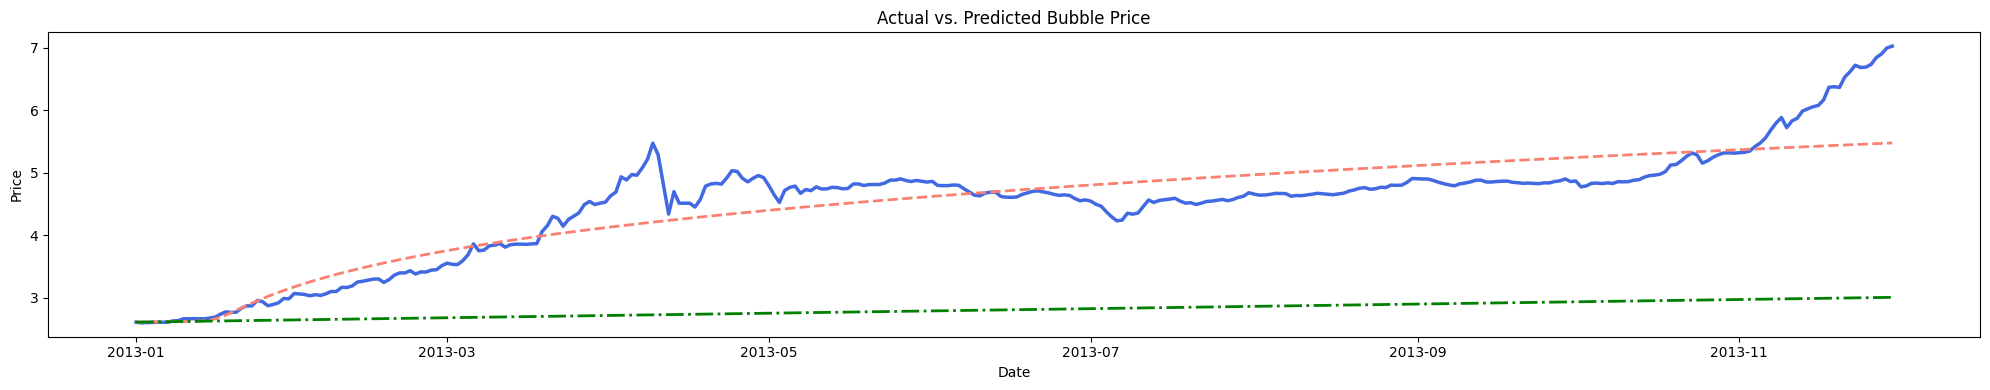

In [91]:
PF_series = PF(times, p0, mu_tilde_hat)
PB_series = PB(times, p0, mu_tilde_hat, v_hat, alpha_hat, beta_hat)
# PB_series = PB(times, p0, mu_tilde, v_hat, 7000, 1000)

plt.figure(figsize=(20, 4))
plt.plot(rolling.index, prices, label='Actual Price', linewidth=2.5, color='royalblue')
plt.plot(rolling.index, PB_series, label='Predicted Bubble Price $P_B(t)$', linestyle='--', color='salmon', linewidth=2)
plt.plot(rolling.index, PF_series, label='Predicted Fundamental Price $P_F(t)$', linestyle='-.', color='green', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Bubble Price')
plt.tight_layout()
plt.show()

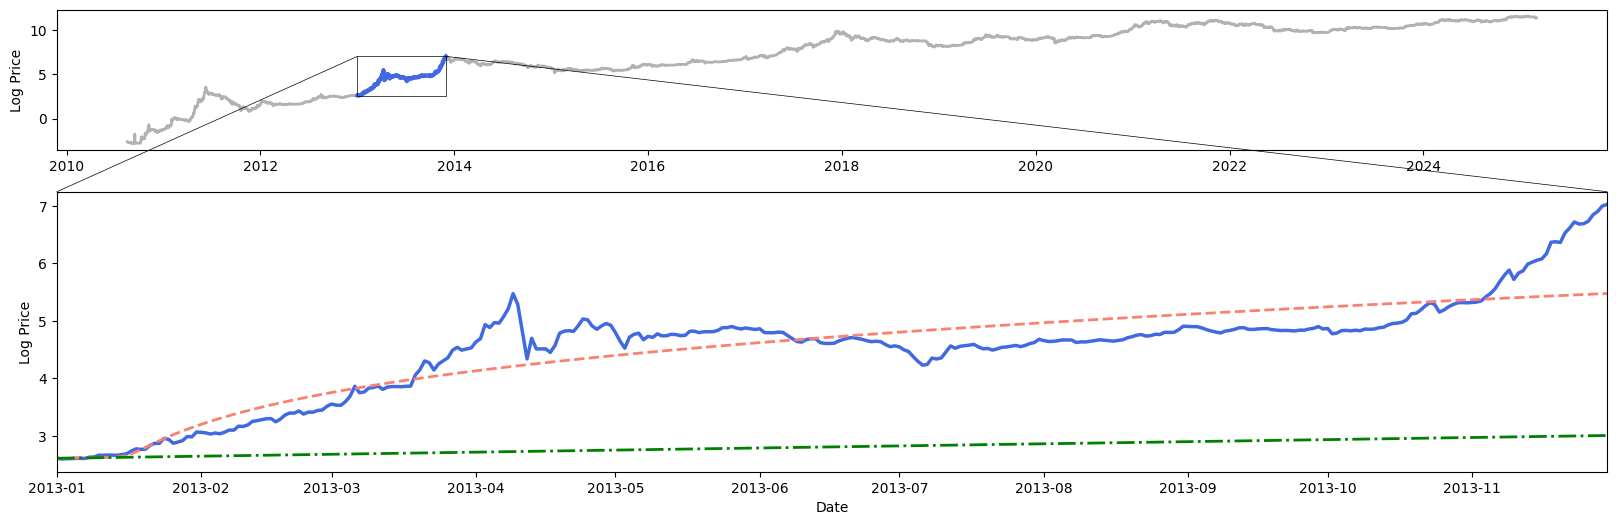

In [92]:
fig, ax = plt.subplots(2, 1, figsize=(20, 6), gridspec_kw={'height_ratios': [1, 2]})

ax[0].plot(btc.index, btc['Log BTC'], color='gray', linewidth=2, alpha=0.6)
highlighted_data = btc.loc[start_date:end_date]
ax[0].plot(highlighted_data.index, highlighted_data['Log BTC'], color='royalblue', linewidth=3, label='Highlighted Range')
ax[0].set_ylabel('Log Price')

x_start = highlighted_data.index[0]
x_end = highlighted_data.index[-1]
y_min = highlighted_data['Log BTC'].min()
y_max = highlighted_data['Log BTC'].max()

box = patches.Rectangle((mdates.date2num(x_start), y_min), width=mdates.date2num(x_end) - mdates.date2num(x_start), height=y_max - y_min, linewidth=0.5, edgecolor='black', facecolor='none', zorder=4, transform=ax[0].transData)
ax[0].add_patch(box)

ax[1].plot(rolling.index, prices, label='Actual Price', linewidth=2.5, color='royalblue')
ax[1].plot(rolling.index, PB_series, label='Predicted Bubble Price $P_B(t)$', linestyle='--', color='salmon', linewidth=2)
ax[1].plot(rolling.index, PF_series, label='Predicted Fundamental Price $P_F(t)$', linestyle='-.', color='green', linewidth=2)
ax[1].set_xlim([rolling.index.min(), rolling.index.max()])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Log Price')

fig.canvas.draw()

for date, x_anchor in zip([highlighted_data.index[0], highlighted_data.index[-1]], [ax[1].get_position().x0, ax[1].get_position().x1]):
    if date == highlighted_data.index[0]:
        y = highlighted_data['Log BTC'].max()
    else:
        y = highlighted_data.loc[date, 'Log BTC']
    
    x_data = mdates.date2num(date)
    start_disp = ax[0].transData.transform((x_data, y))
    start_fig = fig.transFigure.inverted().transform(start_disp)
    end_fig = (x_anchor, ax[1].get_position().y1)
    
    fig.add_artist(Line2D([start_fig[0], end_fig[0]], [start_fig[1], end_fig[1]], transform=fig.transFigure, color='black', linewidth=0.5, zorder=5))
plt.show()

## Table 3: Likelihood ratio tests

In [13]:
def obj_H0(params, times, log_prices, log_p0):
    mu_tilde, alpha, beta = params
    pred = PF(times, log_p0, mu_tilde) # PF(t)
    return np.sum((log_prices - pred) ** 2)

def obj_H1(params, times, log_prices, log_p0):
    v, mu_tilde, alpha, beta = params
    pred = PB(times, log_p0, mu_tilde, v, alpha, beta) # PB(t)
    return np.sum((log_prices - pred) ** 2)

In [35]:
start_date = pd.to_datetime("2010-08-18")
end_date = btc.index[-1]

windows = []
current_start = start_date
while current_start + relativedelta(months=3) <= end_date:
    current_end = current_start + relativedelta(months=3) - pd.Timedelta(days=1)
    windows.append((current_start.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d")))
    current_start += relativedelta(days=3)

lr_results = []

for (start, end) in tqdm(windows):
    sub = btc.loc[start:end].copy()
    sub['t'] = (sub.index - sub.index[0]).days.astype(float)
    times = sub['t'].values
    prices = sub['Log BTC'].values
    p0 = prices[0]

    mu_hat = sub['Returns'].mean()
    var_hat = sub['Returns'].var()
    mu0 = mu_hat + 0.5 * var_hat
    guess_H1 = [0.1, mu0, 1, 1]
    bounds_H1 = [(0, None), (None, None), (1e-5, None), (1e-5, None)]

    res1 = minimize(obj_H1, guess_H1, args=(times, prices, p0), bounds=bounds_H1)
    if res1.success:
        S1 = res1.fun
        v, mu_tilde, alpha, beta = res1.x

        guess_H0 = [mu0, 5, 3]
        bounds_H0 = [(None, None), (1e-5, None), (1e-5, None)]

        res0 = minimize(obj_H0, guess_H0, args=(times, prices, p0), bounds=bounds_H0)
        if res0.success:
            S0 = res0.fun
            n = len(times)
            LR = n * np.log(S0 / S1)
            p = chi2.sf(LR, df=1)

            lr_results.append([f"{start} - {end}", round(p, 3), S0, S1, v, mu_tilde, alpha, beta])

            PF_series = PF(times, p0, res0.x[0])
            PB_series = PB(times, p0, mu_tilde, v, alpha, beta)

            fig, ax = plt.subplots(2, 1, figsize=(20, 6), gridspec_kw={'height_ratios': [1, 2]})

            ax[0].plot(btc.index, btc['Log BTC'], color='gray', linewidth=2, alpha=0.6)
            ax[0].plot(sub.index, prices, color='royalblue', linewidth=3)
            ax[0].set_ylabel('Log Price')
            ax[0].set_title(f"{start} to {end},  P-value = {p:.4f}", fontsize=16, fontweight='heavy')
            bubble_label = "Bubble Period" if p < 0.05 else "Non-Bubble Period"
            bubble_color = "red" if p < 0.05 else "gray"
            ax[0].text(1.0, 1.02, bubble_label, transform=ax[0].transAxes, fontsize=16, color=bubble_color, fontweight='bold', ha='right', va='bottom')

            x_start = sub.index[0]
            x_end = sub.index[-1]
            y_min = sub['Log BTC'].min()
            y_max = sub['Log BTC'].max()

            box = patches.Rectangle((mdates.date2num(x_start), y_min), width=mdates.date2num(x_end) - mdates.date2num(x_start), height=y_max - y_min, linewidth=0.5, edgecolor='black', facecolor='none', zorder=4, transform=ax[0].transData)
            ax[0].add_patch(box)

            ax[1].plot(sub.index, prices, label='Actual Price', linewidth=2.5, color='royalblue')
            ax[1].plot(sub.index, PB_series, linestyle='--', color='salmon', linewidth=2)
            ax[1].plot(sub.index, PF_series, linestyle='-.', color='green', linewidth=2)
            ax[1].set_xlim([sub.index.min(), sub.index.max()])
            ax[1].set_ylabel('Log Price')

            fig.canvas.draw()

            for date, x_anchor in zip([sub.index[0], sub.index[-1]], [ax[1].get_position().x0, ax[1].get_position().x1]):
                y = sub['Log BTC'].max()
                x_data = mdates.date2num(date)
                start_disp = ax[0].transData.transform((x_data, y))
                start_fig = fig.transFigure.inverted().transform(start_disp)
                end_fig = (x_anchor, ax[1].get_position().y1)

                fig.add_artist(Line2D([start_fig[0], end_fig[0]], [start_fig[1], end_fig[1]], transform=fig.transFigure, color='black', linewidth=0.5, zorder=5))

    fn = f"Results/{start}_{end}.png"
    plt.savefig(fn, dpi=72, transparent=True)
    plt.close()


 19%|█▉        | 332/1741 [01:07<08:14,  2.85it/s]/var/folders/0j/0cgjnq7x6_xgggqt92c7300r0000gn/T/ipykernel_3090/1476687902.py:5: RuntimeWarning: overflow encountered in power
  return np.log1p((t / alpha)**beta) # np.log1p(x) = np.log(1+x), more stable
/var/folders/0j/0cgjnq7x6_xgggqt92c7300r0000gn/T/ipykernel_3090/1476687902.py:12: RuntimeWarning: invalid value encountered in multiply
  return log_p0 + mu_tilde * t + (v - v**2 / 2) * Ht
 66%|██████▌   | 1150/1741 [04:41<02:31,  3.91it/s]/var/folders/0j/0cgjnq7x6_xgggqt92c7300r0000gn/T/ipykernel_3090/1476687902.py:5: RuntimeWarning: overflow encountered in power
  return np.log1p((t / alpha)**beta) # np.log1p(x) = np.log(1+x), more stable
/var/folders/0j/0cgjnq7x6_xgggqt92c7300r0000gn/T/ipykernel_3090/1476687902.py:12: RuntimeWarning: invalid value encountered in multiply
  return log_p0 + mu_tilde * t + (v - v**2 / 2) * Ht
100%|██████████| 1741/1741 [07:55<00:00,  3.66it/s]


In [43]:
image_folder = "Results"
png_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png') and os.path.getsize(os.path.join(image_folder, f)) > 2048])

frames = []
for png_file in png_files:
    img = Image.open(png_file).convert("RGBA")
    alpha = img.getchannel("A")

    img = img.convert("RGB").convert("P", palette=Image.ADAPTIVE, colors=256, dither=Image.NONE)

    transparency = 255
    for x in range(img.width):
        for y in range(img.height):
            if alpha.getpixel((x, y)) == 0:
                transparency = img.getpixel((x, y))
                break
        if transparency != 255:
            break

    frames.append(img)

frames[0].save("Bubble_Model_Animation.gif", save_all=True, append_images=frames[1:], duration=15, loop=0, transparency=transparency, disposal=2, optimize=False)

            Time window  p-value        S0        S1        v  mu_tilde      alpha       beta
2010-08-18 - 2010-10-17    1.000  3.483035  3.483035 0.000000  0.000413   1.004535   0.990518
2010-08-25 - 2010-10-24    1.000  3.576981  3.576981 0.000000  0.005698   1.004465   0.990356
2010-09-08 - 2010-11-07    1.000  6.102520  6.102520 0.000000  0.018348   1.004367   0.990213
2010-09-15 - 2010-11-14    1.000 30.989696 30.989696 0.000000 -0.001757   1.004711   0.991280
2010-09-22 - 2010-11-21    1.000  3.007837  3.007837 0.000000  0.028239   1.004815   0.990800
2010-09-29 - 2010-11-28    0.000  3.205764  2.285613 0.078518  0.003173   6.914021   9.211664
2010-10-06 - 2010-12-05    0.000  7.438409  2.765238 0.999985 -0.009338   4.811104   1.675506
2010-10-13 - 2010-12-12    0.000  7.189830  1.124038 0.999999 -0.045246   6.346723   3.162535
2010-10-20 - 2010-12-19    0.000 10.184851  1.017922 0.391519 -0.026149   2.537636   2.323888
2010-11-03 - 2011-01-02    0.230  1.044303  1.019960 0.06069

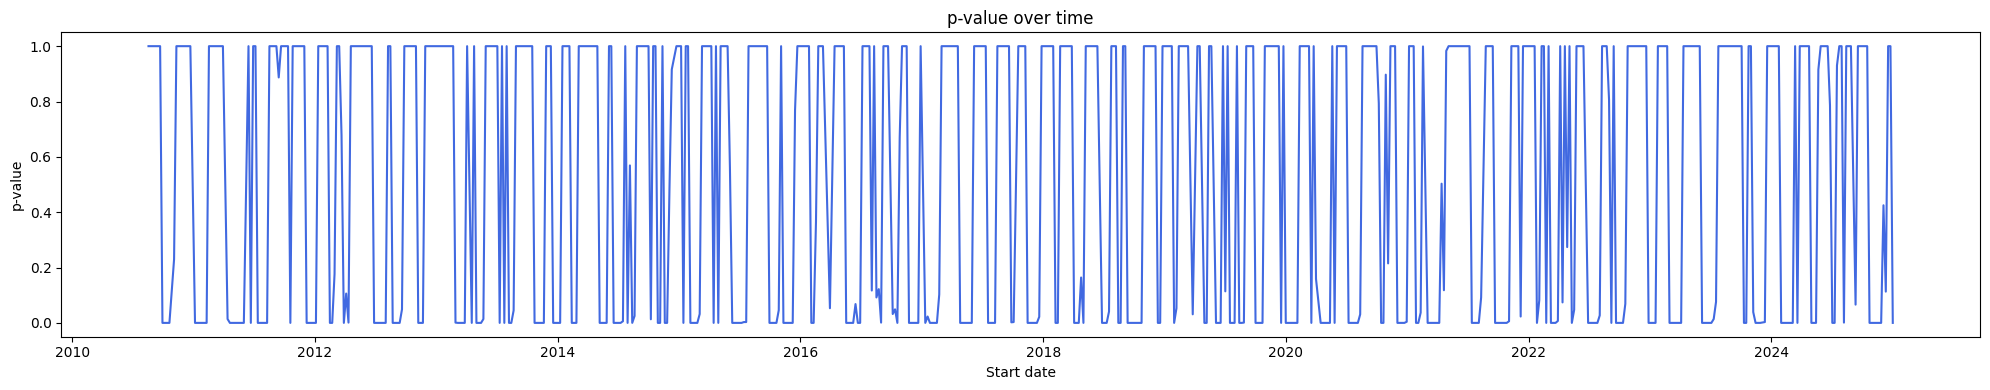

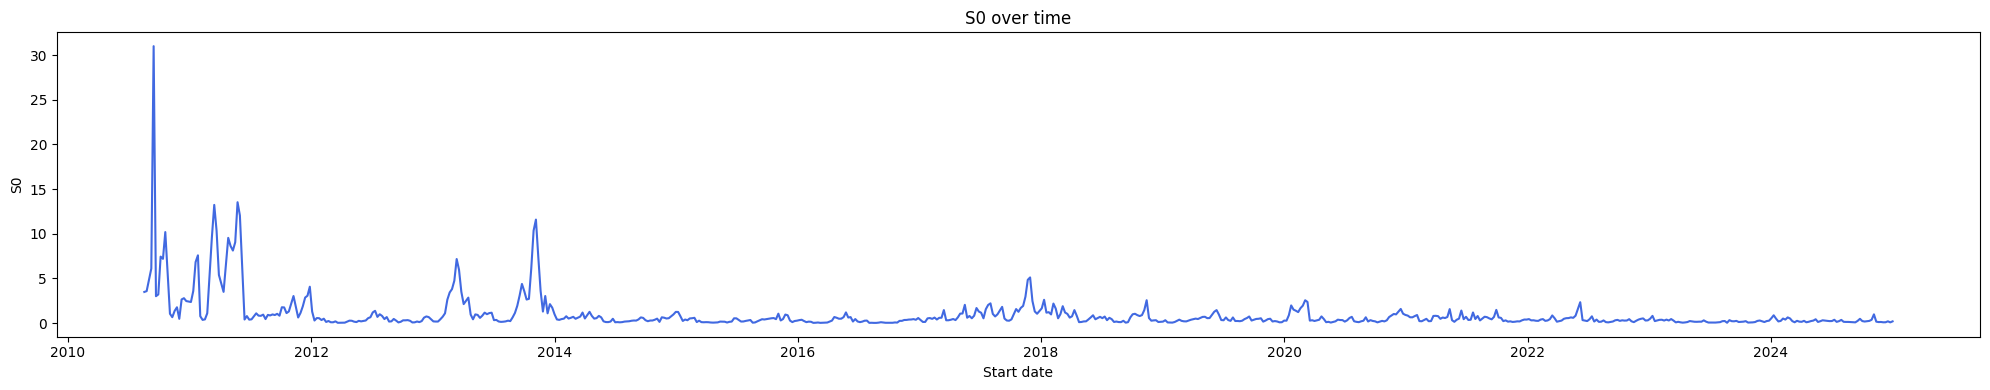

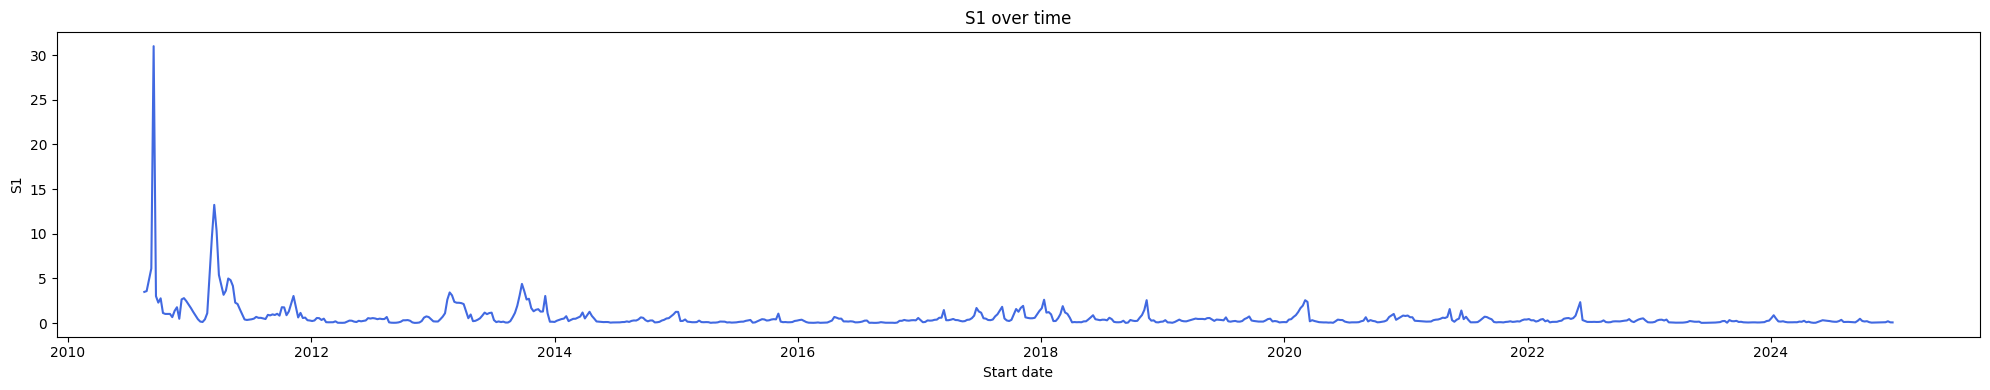

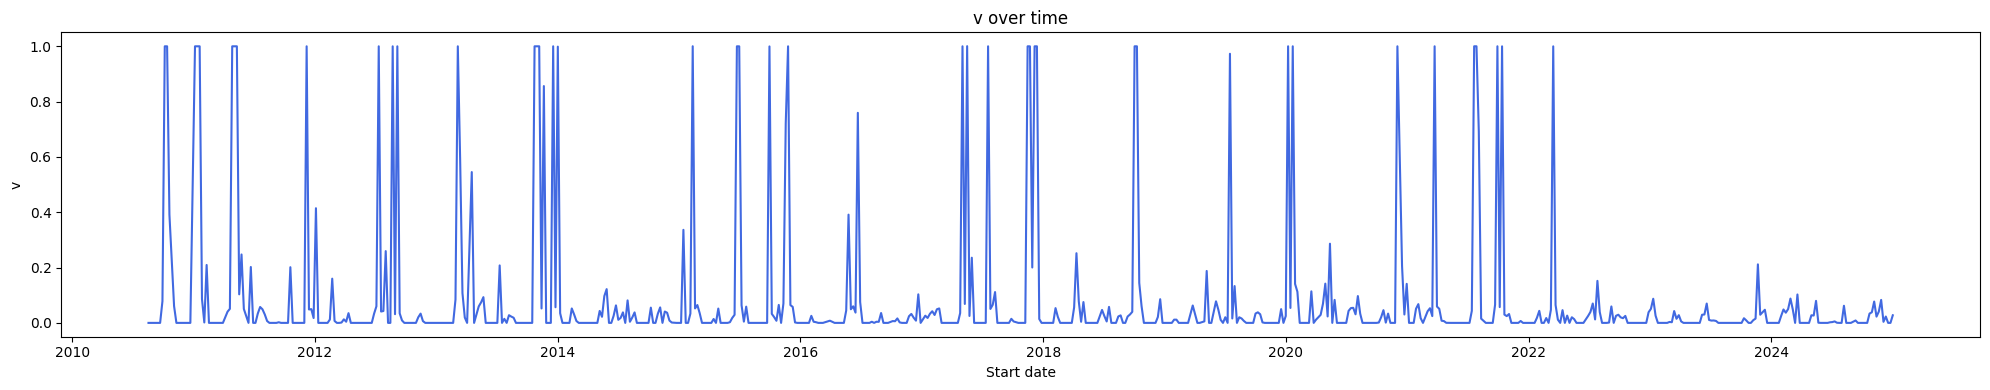

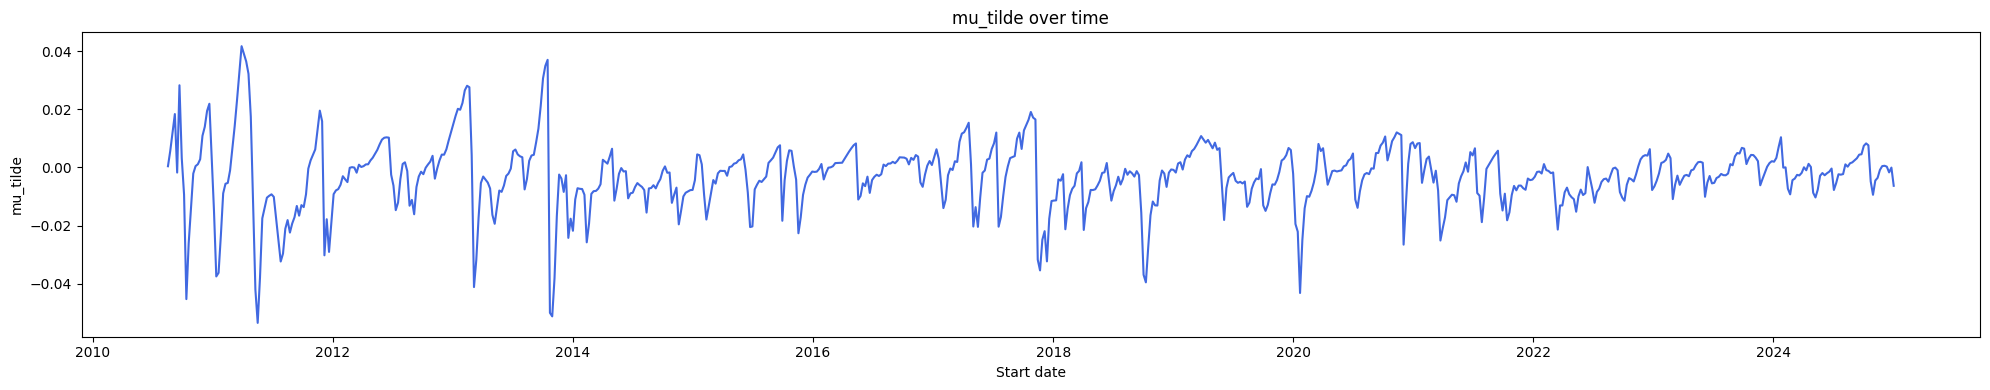

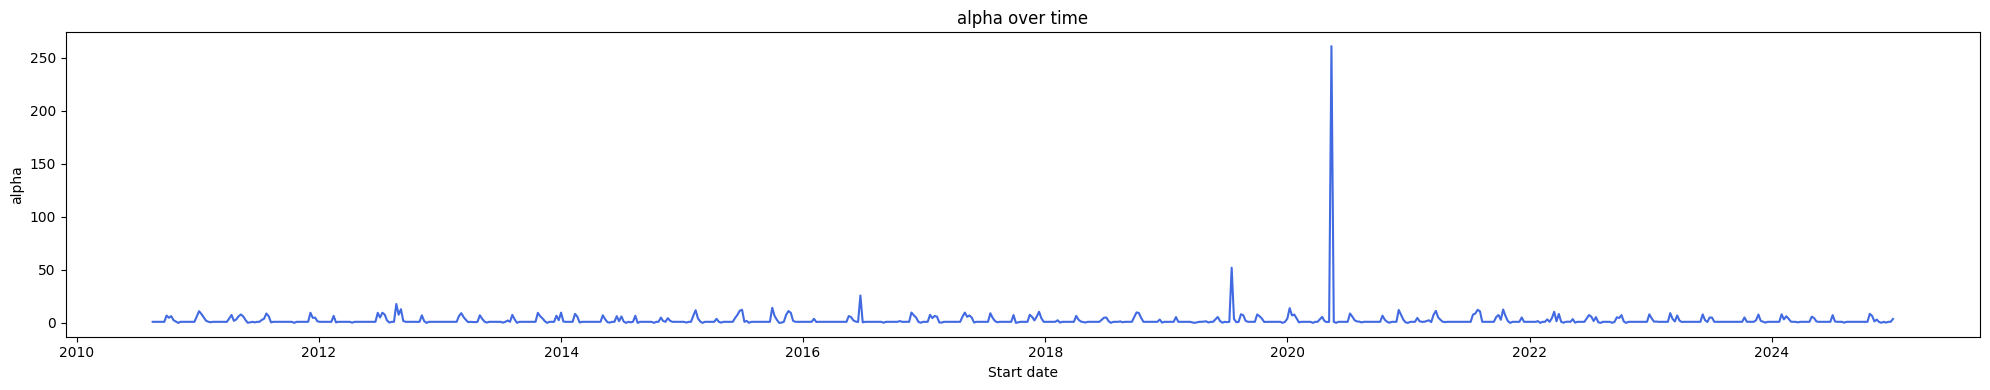

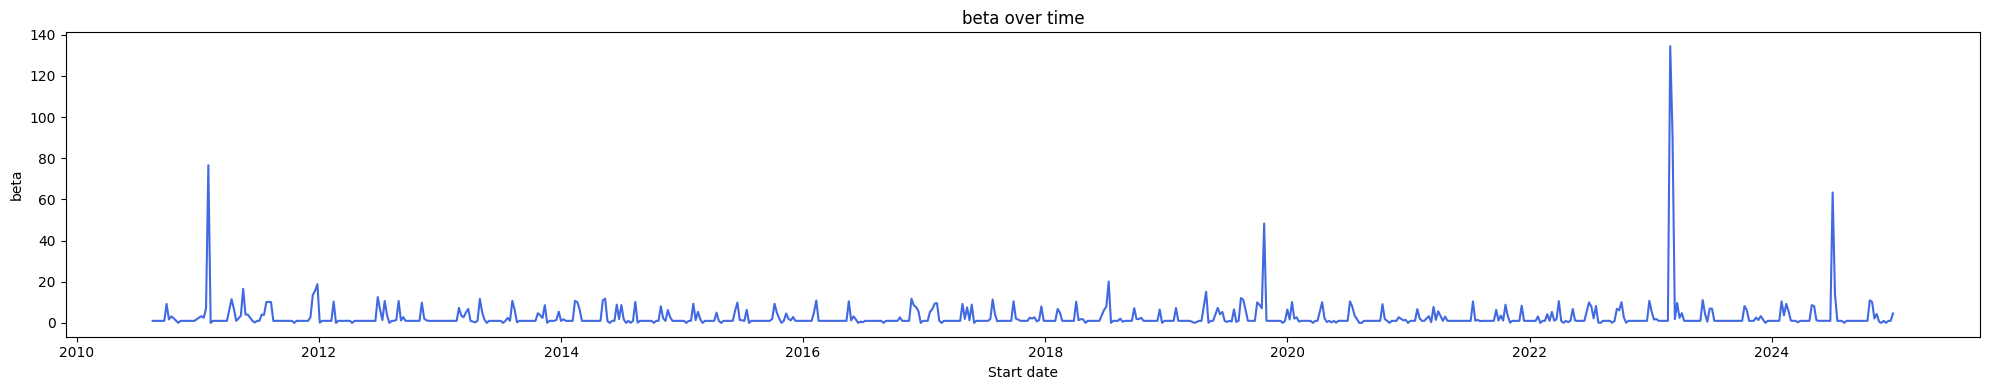

In [59]:
table3 = pd.DataFrame(
    lr_results,
    columns=['Time window', 'p-value', 'S0', 'S1', 'v', 'mu_tilde', 'alpha', 'beta']
)

print(table3.to_string(index=False))

table3['start_date'] = pd.to_datetime(table3['Time window'].str.split(" - ").str[0])

params = ['p-value', 'S0', 'S1', 'v', 'mu_tilde', 'alpha', 'beta']

for param in params:
    plt.figure(figsize=(20, 4))
    plt.plot(table3['start_date'], table3[param], color='royalblue')
    plt.title(f'{param} over time')
    plt.xlabel('Start date')
    plt.ylabel(param)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [60]:
import glob
import imageio


png_files = sorted(glob.glob('Results/*.png'))
images = [imageio.imread(fp) for fp in png_files]
imageio.mimsave('Results/bubble_evolution.gif', images, duration=0.5)

/var/folders/0j/0cgjnq7x6_xgggqt92c7300r0000gn/T/ipykernel_19701/2190235714.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in png_files]
